In [1]:
'''
code written by natalie ko-ferrigno 🏳️‍⚧️ (mkf1g21@soton.ac.uk), let me know if you use it
it uses the nodal results for displacements and stresses from APDL
it also uses the positions of the nodes from APDL
i will probably not help you use it because i have a report to write

'''
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import time


In [2]:
def ingest_data(path):
    ''' read in the location of the node from ansys'''
    locations = []
    with open(f'results/{path}/locations', 'r') as file:
        for line in file:

            try:

                words = line.strip().split()
                node = {
                    "num": float(words[0]),
                    "x": float(words[1]),
                    "y": float(words[2]),
                    "z": float(words[3]),
                }
                locations.append(node)
            except:
                continue

    df = pd.DataFrame(locations)
    
    results = []
    with open(f'results/{path}/xdisp', 'r') as file:
        for line in file:
            try:
                words = line.strip().split()
                float(words[0])
                results.append(float(words[1]))
            except:
                continue
    df = df.assign(xdisp=results)

    results = []
    with open(f'results/{path}/ydisp', 'r') as file:
        for line in file:
            try:
                words = line.strip().split()
                float(words[0])
                results.append(float(words[1]))
            except:
                continue
    df = df.assign(ydisp=results)

    results = []
    with open(f'results/{path}/zdisp', 'r') as file:
        for line in file:
            try:
                words = line.strip().split()
                float(words[0])
                results.append(float(words[1]))
            except:
                continue
    df = df.assign(zdisp=results)

    '''read in the von mieses stresses'''
    results = []
    n=0
    '''
    this is a bit more complex, as some nodes have 6 data entries, but some have as low as 2 stresses.
    I keep count of which node the loop is on, which is what n is for.
    the code makes a list of the von mieses stresses for each entry.
    '''
    #with open(f'results/{path}/vms', 'r') as file:
    with open(f'results/{path}/vms', 'r') as file:
        for line in file:
            try:
                words = line.strip().split()
                if int(words[0]) != n:
                    '''
                    if the node that the code is looking at has changed, make a new list to store this information in
                    '''
                    n += 1
                    results.append([])

                results[n-1].append(float(words[-2]))
            except:
                continue

    '''bring all of the arrays up to a length of 6.
    to show that the new data doesnt mean anything, fill these new entrys with NaN so that max and min still work
    '''
    for result in results:
        while len(result) < 6:
            result.append(np.NaN)

    res = np.array(results)

    ''' put these arrays into the dataframe'''
    df = df.assign(vms_0 = res[:,0])
    df = df.assign(vms_1 = res[:,1])
    df = df.assign(vms_2 = res[:,2])
    df = df.assign(vms_3 = res[:,3])
    df = df.assign(vms_4 = res[:,4])
    df = df.assign(vms_5 = res[:,5])

    '''store the maximum von mieses stresses'''
    vms_maxes = []
    for j in range(len(df)):
        ''' this line is a bit ugly, but it just goes through each von meises stress entry and finds the maximum value of stress'''
        vms_maxes.append(max([df[f"vms_{i}"][j] for i in range(6)]))
    df = df.assign(vms_max = vms_maxes)
    
    return df

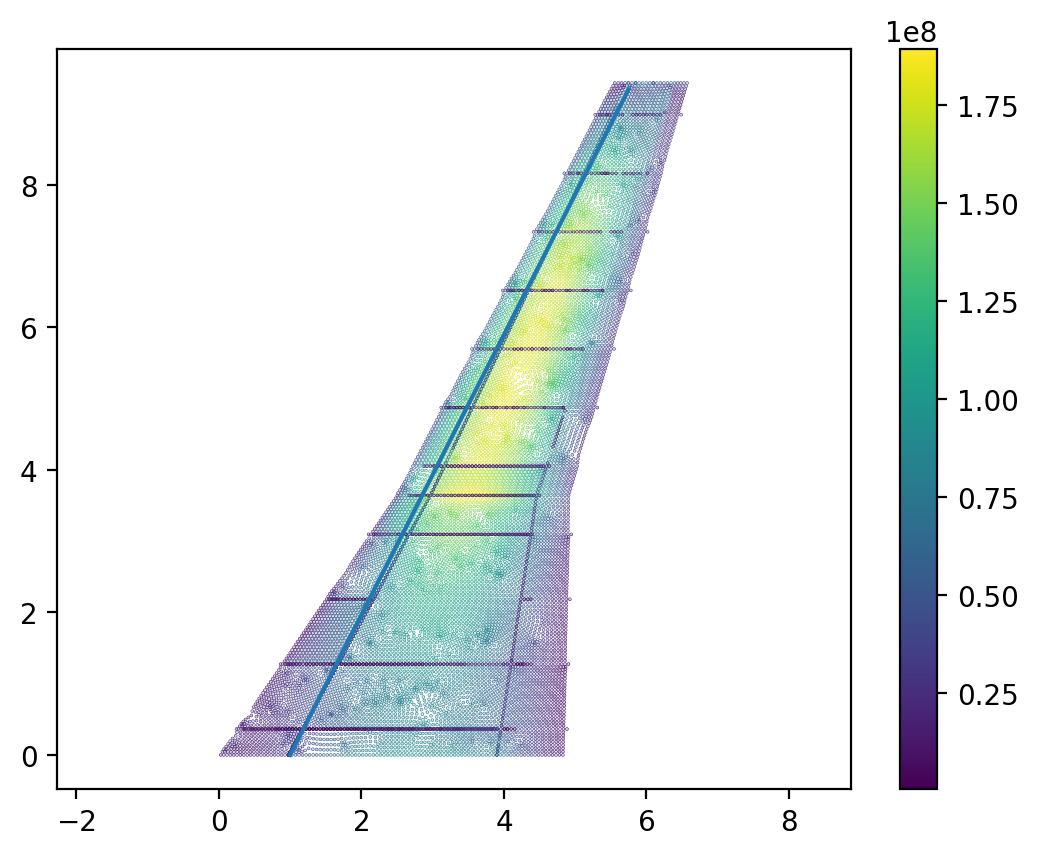

In [3]:
wing_up_cantilever = ingest_data("sec1_cantilever_up")
wing_up_simple = ingest_data("sec1_simple_up")
no = ingest_data("do_not_trust")
cup = ingest_data("c_up")

len_linspace = 50 # this is the number of nodes on the path, increasing its value will make it take longer but be more accurate

xs = np.linspace(1, 5.75, len_linspace)
ys = np.linspace(0, 9.34, len_linspace)

'''this is a horrific scatter, but it just shows where each node is and what stress it is experiencing'''
plt.scatter(wing_up_cantilever["x"][np.where(wing_up_cantilever["z"]>0)[0]], wing_up_cantilever["y"][np.where(wing_up_cantilever["z"]>0)[0]], c = wing_up_cantilever['vms_max'][np.where(wing_up_cantilever["z"]>0)[0]], s=0.05)
plt.plot(xs, ys)
plt.axis('equal')
plt.colorbar()

In [4]:
'''
this takes in the path defined above and finds the node closest to each point on the path.

for each point in the path, it goes over every node in the dataframe. 
it finds the distance between the point on the path and the node.
it stores the ID of the node that is closest to the point on the path
'''
def find_path(xs, ys, dataset):
    print()
    points = []
    for i in range(len_linspace):
        print(f"{(i+1)/len_linspace*100:2.1f}% done", end="\r")
        least_distance = np.inf
        closest_node = np.nan
        for node_num in range(len(dataset)):
            if dataset['z'][node_num] < 0:
                distance = np.sqrt((ys[i] - dataset['y'][node_num])**2 + (xs[i] - dataset['x'][node_num])**2)
                if distance < least_distance:
                    least_distance = distance
                    closest_node = node_num
        points.append(closest_node)
    return points


100.0% done
100.0% done


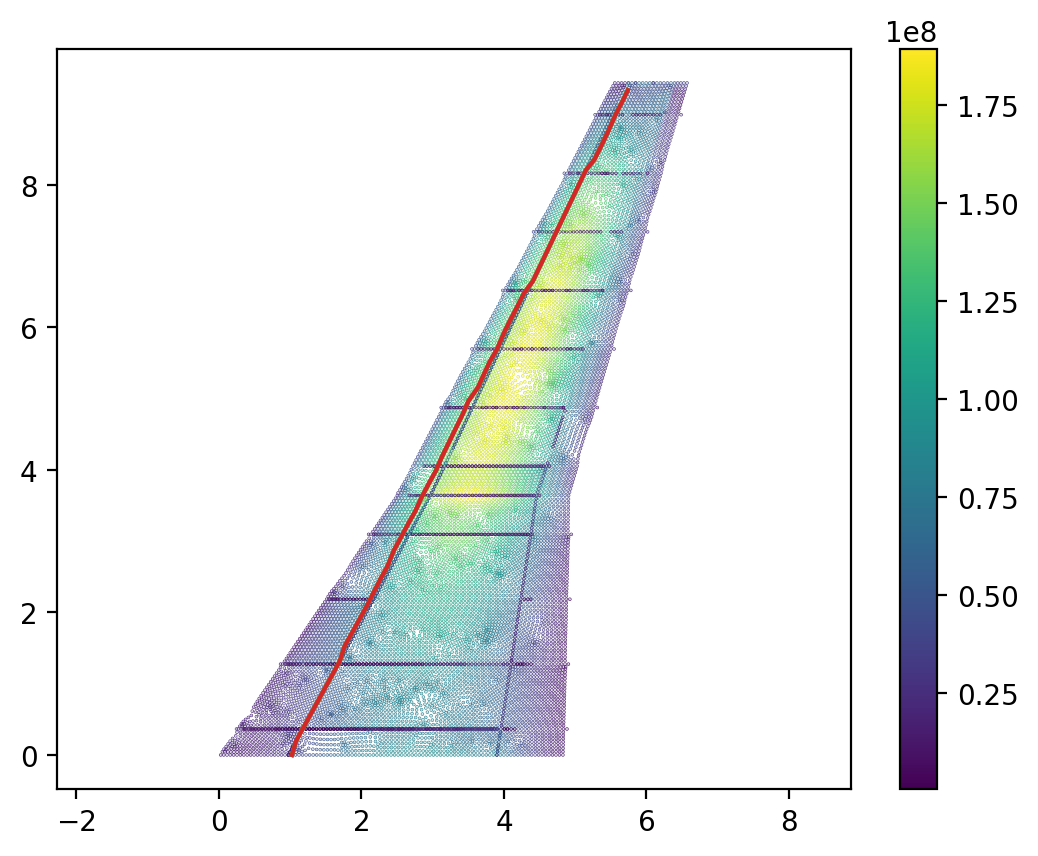

In [5]:
path_up_canti = find_path(xs, ys, wing_up_cantilever)
path_up_simple = find_path(xs, ys, wing_up_simple)
path_cup = find_path(xs, ys, cup)
'''
this shows the nodes selected for the path overlayed on the wing
'''
plt.scatter(wing_up_cantilever["x"][np.where(wing_up_cantilever["z"]>0)[0]], wing_up_cantilever["y"][np.where(wing_up_cantilever["z"]>0)[0]], c = wing_up_cantilever['vms_max'][np.where(wing_up_cantilever["z"]>0)[0]], s=0.05)

plt.plot(wing_up_cantilever['x'][path_up_canti], wing_up_cantilever['y'][path_up_canti])
plt.plot(wing_up_simple['x'][path_up_simple], wing_up_simple['y'][path_up_simple])
plt.plot(cup['x'][path_cup], cup['y'][path_cup])
plt.plot(no['x'][path_up_simple], no['y'][path_up_simple])
plt.axis('equal')
plt.colorbar()

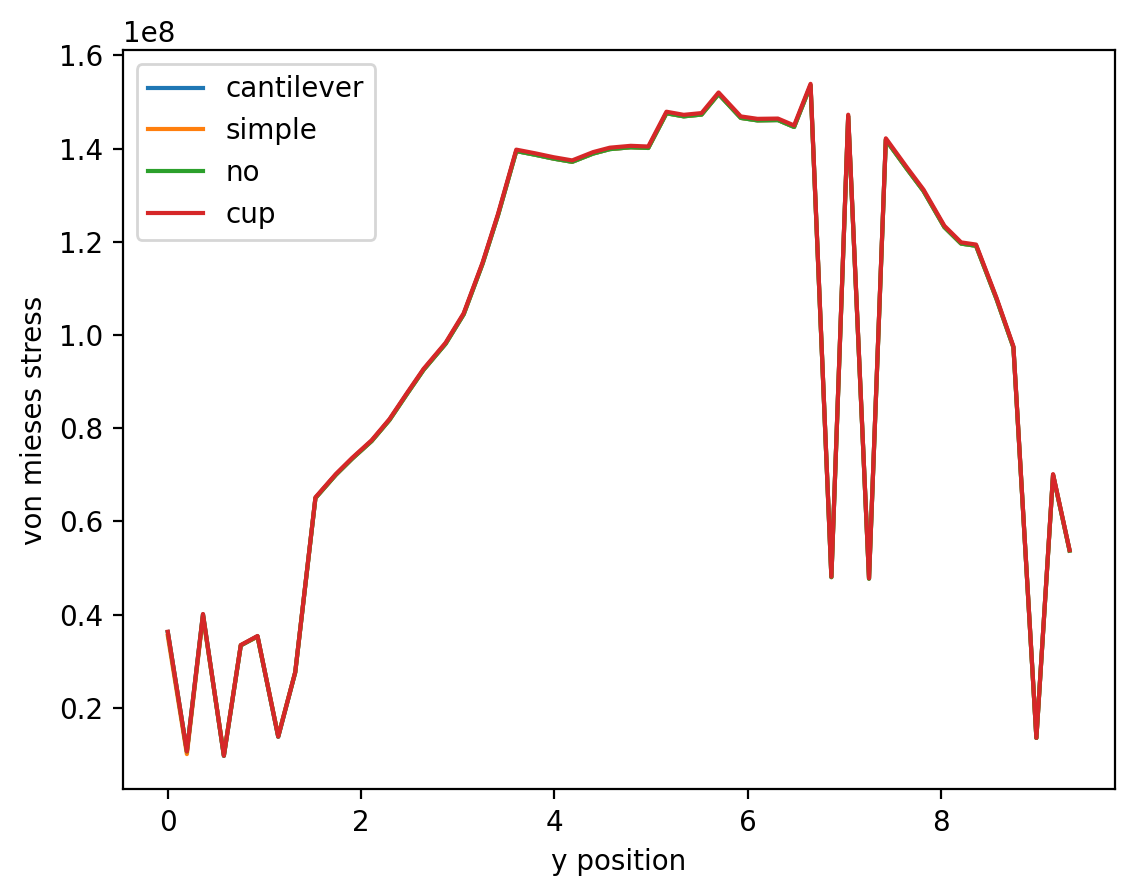

In [6]:
plt.plot(wing_up_cantilever['y'][path_up_canti], wing_up_cantilever['vms_max'][path_up_canti], label="cantilever")
plt.plot(wing_up_simple['y'][path_up_simple], wing_up_simple['vms_max'][path_up_simple], label="simple")
plt.plot(no['y'][path_up_simple], no['vms_max'][path_up_simple], label="no")
plt.plot(cup['y'][path_cup], cup['vms_max'][path_cup], label="cup")

plt.xlabel("y position")
plt.ylabel("von mieses stress")
plt.legend()

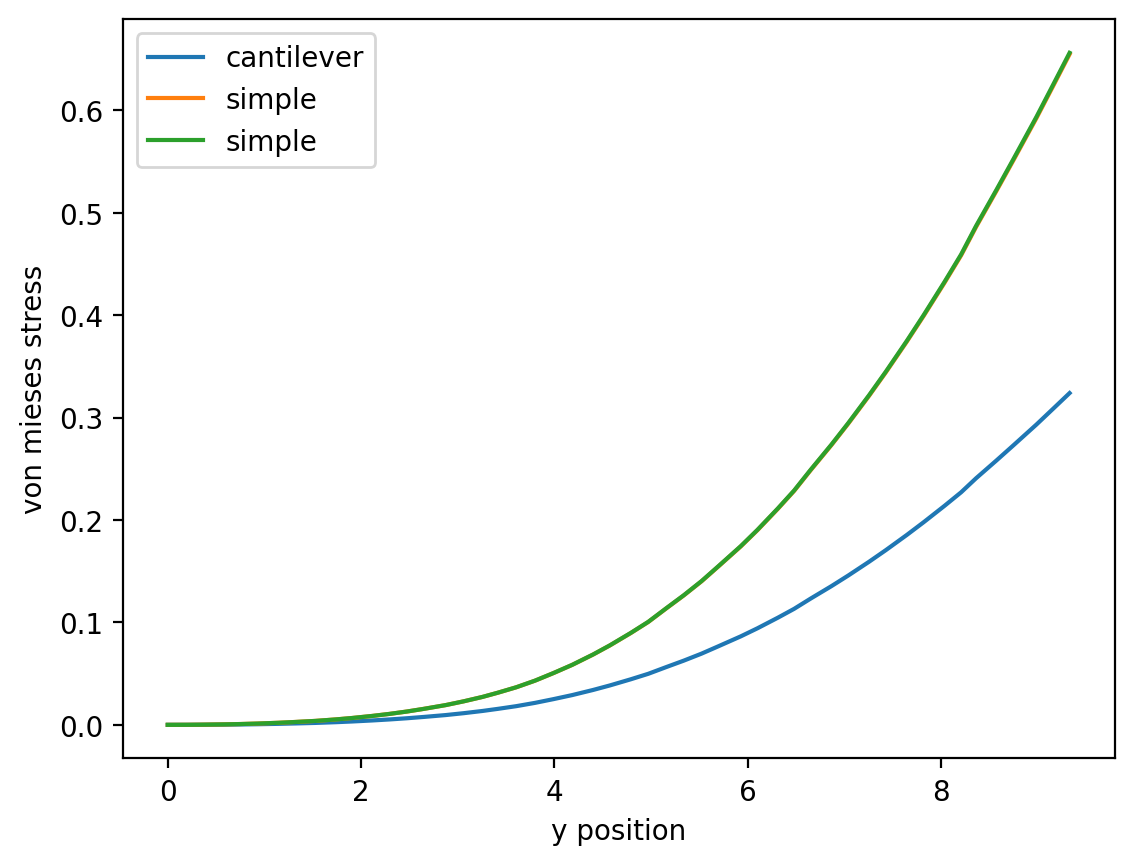

In [7]:
plt.plot(wing_up_cantilever['y'][path_up_canti], wing_up_cantilever['zdisp'][path_up_canti], label="cantilever")
plt.plot(wing_up_simple['y'][path_up_simple], wing_up_simple['zdisp'][path_up_simple], label="simple")
plt.plot(cup['y'][path_cup], cup['zdisp'][path_cup], label="simple")


plt.xlabel("y position")
plt.ylabel("von mieses stress")
plt.legend()